# Защита персональных данных клиентов

**Исходные данные:**
данные с признаками застрахованных клиентов(пол, возраст, зарплата, количество членов семьи) и целевым признаком(количество страховых выплат клиенту за последние 5 лет)


**Цель:**
разработка метода преобразования данных, с учетом последующего их использования в модели машинного обучения, для защиты персональных данных


**Этапы исследования:**

1. <a href=#download_data id="first">Загрузка исходных данных и их общая оценка</a>
2. <a href=#multiply>Умножение признаков на обратную матрицу</a>
3. <a href=#algorithm>Алгоритм преобразования данных</a>
4. <a href=#checking>Проверка алгоритма на модели</a> 
5. <a href=#conclusion>Заключение</a> 


Загрузите и изучите данные.
Ответьте на вопрос и обоснуйте решение.
 Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)
 a. Изменится. Приведите примеры матриц.
 b. Не изменится. Укажите, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.
Предложите алгоритм преобразования данных для решения задачи. Обоснуйте, почему качество линейной регрессии не поменяется.
Запрограммируйте этот алгоритм, применив матричные операции. Проверьте, что качество линейной регрессии из sklearn не отличается до и после преобразования. Примените метрику R2.

## <a href=#first id='download_data'>1 Загрузка исходных данных </a>

In [1]:
!pip install -U ydata-profiling[notebook] --quiet install
!pip install matplotlib --upgrade --quiet install
!pip install seaborn --upgrade --quiet install
!pip install schemdraw --quiet install

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.2 requires matplotlib<3.7,>=3.2, but you have matplotlib 3.7.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns
import schemdraw

from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from schemdraw.flow import *


RANDOM_STATE = 42

In [3]:
class ShowData:
    '''

    there are the methods for help to look thought the data
    "download_data" open dataset(download) from collab and from other paths,
    "change_data" replaces name of columns according to PEP8 and convert to lower data type,
    "general_info" provides with the numbers of columns/rows, type of columns and occupied memory,
    "deep_info" provides with statistic info and info for preprocessing step,
    "hist_box" shows histograms and boxplots for each numeric column (DON'T FORGET TO CHANGE THE GRAPH SIZE),
    "cor_matrix" shows correlation matrix for all numeric columns, it uses Pearson coefficient

    '''
    def download_data(self, path):

        import os
        if os.path.exists(path):
            df = pd.read_csv(path)
        elif os.path.exist(path):
            from google.colab import drive
            drive.mount('/content/drive')
            df = pd.read_csv(path)
        else:
            print("The path doesn't exist")

        return df

    def change_data(self, df):

        df.columns = (df.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.lower())
        try:
            for name in df.select_dtypes("number").columns:
                df[name] = pd.to_numeric(df[name], downcast="float"
                                        if (data["age"] // 1 == 0).all()
                                        else "integer")
        except:
            pass
        return df

    def general_info(self, df):

        info_0 = pd.DataFrame(df.dtypes.value_counts(), columns=[""])
        info_0.loc["columns", ""] = len(df.columns)
        info_0.loc["row", ""] = len(df)
        info_0.loc["memory_usage, MB", ""] = df.memory_usage()\
        .sum() / (1024 ** 2)

        return info_0

    def deep_info(self, df):

        info_1 = pd.DataFrame(index=df.columns, columns=['rows'], data=len(df))
        info_1["null_row"] = df.apply(lambda x: x == 0, axis=1).sum()
        info_1["uniq"] = df.nunique()
        info_1["dup_val"] = [df[i].duplicated().sum() for i in df]
        info_1["dup_row"] = df.duplicated().sum()
        info_1["NaN"] = df.isna().sum()
        info_1["NaN,%"] = df.isna().mean()
        info_1["type"] = df.dtypes
        info_1 = info_1.join(df.describe(include="number")["mean":].transpose())
        info_1.fillna("", inplace=True)
        for col in info_1.loc[:, "mean":]:
            info_1[col] = pd.to_numeric(info_1[col], downcast="float")
        info_1["null_row"] = pd.to_numeric(info_1["null_row"], downcast="integer")
        info_1["outliers"] = info_1["max"] > info_1["75%"] \
                             + 1.5 * (info_1["75%"] - info_1["25%"])

        prop = {
            "border": "0.5px solid black",
            "width": "85px",
            "text-align": "center"
        }
        percent = {
            "NaN,%":"{:.3%}",
            "mean":"{:.3}",
            "std":"{:.3}",
            "min":"{:.3}",
            "25%":"{:.3}",
            "50%":"{:.3}",
            "75%":"{:.3}",
            "max":"{:.3}",
        }

        return info_1, info_1.style.format(percent).set_properties(**prop) 

    def hist_box(self, df):

        length = len(df.columns)
        df_num = df.select_dtypes("number")
        fig = plt.figure(figsize=(length*3,length))
        sfigs = fig.subfigures(round(length/4), 4)
        for i, axes in enumerate(sfigs.flat):
            try:
                axes.suptitle(df_num.columns[i])
                if len(df.iloc[:,i]) > 0:
                    ax_1= axes.subplots(2, 1, sharex=True,
                                        gridspec_kw={"height_ratios": (.15, .85)})
                    sns.boxplot(data=df, x=df_num.columns[i], orient="h",
                                ax=ax_1[0])
                    sns.histplot(data=df, x=df_num.columns[i], kde=True,
                                 ax=ax_1[1])
                    plt.xlabel("")
                    plt.ylabel("")
            except:
                break
        plt.show()

    def cor_matrix(self, df):

        length = len(df.columns)
        plt.figure(figsize=(length, length))
        sns.heatmap(df.corr(method="pearson"), annot=True, linewidths=0.3,
            cmap="coolwarm", square=True)
        plt.show()

In [4]:
# create a variable for class
sd = ShowData()

In [5]:
# download data
data = sd.download_data("insurance.csv")

In [6]:
# show first 5 rows
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [7]:
# for more convenience to rename the columns
data.rename(columns={
    "Пол":"sex",
    "Возраст":"age",
    "Зарплата":"wages",
    "Члены семьи":"family_members",
    "Страховые выплаты":"insurance_payments"
}, inplace=True)

In [8]:
# use attribute of class and look at the numbers of columns
sd.general_info(data)

,
int64,3.000000
float64,2.000000
columns,5.000000
row,5000.000000
"memory_usage, MB",0.190857


In [9]:
# obviously that a few columns have incorrect type
data["age"] = pd.to_numeric(data["age"], downcast="integer")
data["wages"] = data["wages"].astype(np.int32)

In [10]:
# convert to the lower possible type
sd.change_data(data)

,sex,age,wages,family_members,insurance_payments
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0
...,...,...,...,...,...
4995,0,28,35700,2,0
4996,0,34,52400,1,0
4997,0,20,33900,2,0
4998,1,22,32700,3,0


In [11]:
# and look at the types again
sd.general_info(data)

,
int8,4.000000
int32,1.000000
columns,5.000000
row,5000.000000
"memory_usage, MB",0.038269


In [12]:
#analyzing the dataset
ProfileReport(data, title="Pandas Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
data.shape

(5000, 5)

In [14]:
data.drop_duplicates(inplace=True)

In [15]:
data.shape

(4847, 5)

### Вывод

Все признаки и целевой признак представлены числовым типом данных. Возраст и зарплата являются количественными признаками, а все остальные - категориальными. Распределение значений зарплаты приближено к нормальному, в то время как распределение возраста имеет особенности из-за ограничений по возрасту для застрахованного.
Для всех столбцов был изменен тип данных. Пропущенные значения не обнаружены. Были удалены дубликаты строк, которые составляют 3%. В столбцах, содержащих количество членов семьи и количество страховых выплат, были обнаружены нулевые значения, что объяснимо в связи с наличием клиентов без дополнительных членов семьи. Так как довольно много клиентов - молодые люди в возрасте 18, то наличие более 30% нулевых значений объяснимо. Аналогичная ситуация для целевого признака. Наличие корреляции между признаками находится в допустимых пределах для обучения модели.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех 👍: 
    
EDA проведено.  


- Здорово чтоб поработала с типами данных 
    
    
- Помнишь стилистике
    
    
    
Использовала отличную библиотеку

## 2 Умножение признаков на матрицу <a id="multiply"> </a>

In [16]:
np.linalg.inv([
    [1,1,3],
    [4,5,6],
    [7,8,11]
])

array([[-1.75, -3.25,  2.25],
       [ 0.5 ,  2.5 , -1.5 ],
       [ 0.75,  0.25, -0.25]])

In [17]:
np.ones((3, 1))

array([[1.],
       [1.],
       [1.]])

 Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Свойства обратных и транспонированных матриц, которые будут использоваться при преобразовании:
$$
(AB)^T = B^TA^T,
$$

$$
(A*B)*C = A*(B*C),
$$

$$
(AB)^{-1} = B^{-1}A^{-1}
$$

$$
A * E = E * A = A,~где ~ E - единичная~матрица$$


Если мы умножаем признаки, представленные прямоугольной матрицей, для которой не существует такого $$X^{-1},$$
чтобы
$$
XX^{-1} = X^{-1}X = E
$$
на обратимую(квадратную ) матрицу P, для которой
$$
PP^{-1} = P^{-1}P = E,
$$
то формула предсказаний принимает вид
$$
а_2 = X_2w_2 = XPw_2
$$
Докажем что
$$
а_2 = a,
$$
подставив значения функции линейной регрессии в правую и левую часть получим уравнение вида
$$
XPw_2 = Xw,
$$
где формула обучения для левой части имеет вид
$$
w_2 = ((XP)^T * XP)^{-1} * (XP)^T * y.
$$
Подставим формулы обучения в обе части равенства
$$
XP*((XP)^T * X*P)^{-1} * (XP)^T * y = X*(X^T * X)^{-1} * (X)^T * y.
$$
Выполним преобразования в соответствии со свойствами матриц, представленными выше:
$$
XP*((XP)^T * X*P)^{-1} * (XP)^T * y = X*(X^T * X)^{-1} * (X)^T * y,
$$
$$
XP*(P^TX^T * X*P)^{-1} * P^TX^T * y = X*(X^T * X)^{-1} * (X)^T * y,
$$
$$
XP*(P^T*(X^T * X*P))^{-1} * P^TX^T * y = X*(X^T * X)^{-1} * (X)^T * y,
$$
$$
XP*((X^T * X)*P)^{-1}*(P^T)^{-1} * P^TX^T * y = X*(X^T * X)^{-1} * (X)^T * y,
$$
$$
X*(P*P^{-1})*(X^T * X)^{-1}*((P^T)^{-1} * P^T)*X^T * y = X*(X^T * X)^{-1} * (X)^T * y,
$$

$$
X*(X^T * X)^{-1}*X^T * y = X*(X^T * X)^{-1} * (X)^T * y,
$$
Исходя из этого
$$
а_1 = XPP^{-1}w_1 = Xw = a,
$$
где
$$
P^{-1}w_1 = w
$$
чтд.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:




Самая частая ошибка - не учитывают что обратная матрица может быть только у квадратной.  Часто не соблюдают правила матричного преобразования, или меняют матрицы местами при перемножении как цифры.  


У тебя все ОК. 
    
    
    
    
<div class="alert alert-warning">



Совет 🤔:    
    
    
    

  
Есть ещё один способ доказательства   когда мы берём
    
    
$$
w = \arg\min_w MSE(Xw, y)
$$
    
  
и     
    
$$
w_P = \arg\min_w MSE(XPw_p, y)
$$  
    
    
И делая  замену    w_p, видим что задача  
    
$$
\arg\min_w MSE(XPw_p, y)
$$
    
сводится к     
  
    
$$
\arg\min_w MSE(Xw, y)
$$    


Осталось только догадаться какую замену мы делаем.  Можешь попробовать решить и таким способом  

  
</div>
    

    






<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка ❌:
    

  
Нет ответа на "как связаны параметры линейной регрессии в исходной задаче и в преобразованной"

Какое соотношение между $w$ и $w_p$?
    
    
Где   



$$
w = (X^T X)^{-1} X^T y
$$
    
    
$$
w_P = ((XP)^T XP)^{-1} (XP)^T y
$$   



### Вывод
Если признаки умножают на обратимую матрицу, то качество линейной регрессии не изменится. Это происходит потому, что при умножении матрицы признаков на обратимую матрицу, веса модели (которые мы настраиваем в процессе обучения) будут адаптироваться к новым значениям признаков таким образом, чтобы минимизировать ошибку предсказания.

## 3 Алгоритм преобразования <a id="algorithm"></a>

Так как мы доказали, что при умножении признаков на обратную матрицу качество линейной регрессии не изменится, то воспользуемся этим свойством и проверим его на практике



<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Людмила, тут мы по пунктам расписываем словами порядок наших действий, с учетом: что за матрица, каким уcловиям она должна соответствовать, какого размера, что на что перемножаемых, что делаем если сгенерированная Матрица необратимая итд итп. Это и называется алгоритм. Там целая теория, можно схемы [рисовать](https://yandex.ru/images/search?pos=0&img_url=http%3A%2F%2Fimages.myshared.ru%2F6%2F674342%2Fslide_13.jpg&text=%D0%9F%D1%80%D0%B0%D0%B2%D0%B8%D0%BB%D0%B0%20%D0%BD%D0%B0%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D1%8F%20%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B0%20%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B0%20%D0%BD%D0%B0%20%D0%BF%D0%B8%D1%82%D0%BE%D0%BD%D0%B5&lr=43&rpt=simage&source=serp&rlt_url=https%3A%2F%2Ffs.znanio.ru%2Fd5af0e%2F50%2F9c%2Ffc07a3f83eed5c7e727ae0bb808ea8b774.jpg&ogl_url=http%3A%2F%2Fimages.myshared.ru%2F6%2F674342%2Fslide_13.jpg)


А затем на основе этого и пишем код ниже

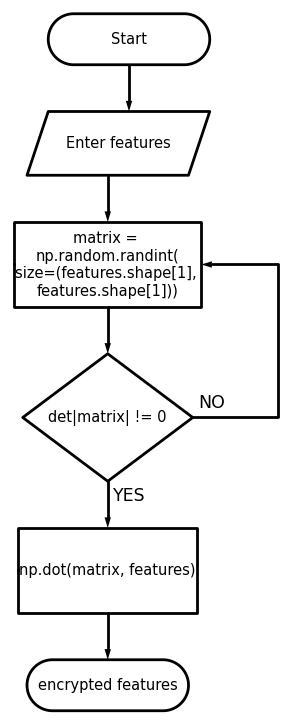

In [18]:

with schemdraw.Drawing() as d:
    # define size of text and length of arrows
    d.config(fontsize=12, unit=1.1)
    # steps and arrows for the steps 

    d += Start(w=3.8, h=1.2).label("Start")
    d += Arrow()

    d += Data(w=3.8, h=1.5).label("Enter features")
    d += Arrow()

    d += (d1 := Box(w=4.4, h=2).label("matrix = \nnp.random.randint(\nsize=(features.shape[1], \nfeatures.shape[1]))"))
    d += Arrow()

    d += (d2 := Decision(S="YES", E="NO", w=4, h=3).label("det|matrix| != 0"))
    d += Wire('c',  k=2, arrow='->').at(d2.E).to(d1.E)
    d += Arrow().down().at(d2.S)

    d += Box(w=4.2, h=2).label("np.dot(matrix, features)")
    d += Arrow()

    d += Start(w=3.8, h=1.2).label("encrypted features")

    

 


In [19]:
# split data into the features and targets
X = data.iloc[:, :-1]
y = data.insurance_payments
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [20]:
class LModel:

    ''' define functions for studying the model 
    and checking the accuracy of the model '''


    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)),
                            train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T @ X) @ X.T @ y
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

    def score_r2(self, target, predictions):
        ss_res = ((target - predictions) ** 2).sum()
        ss_tot = ((target - target.mean()) ** 2).sum()
        r2 = 1 - ss_res / ss_tot
        return r2

In [21]:
def inv_matrix(num_cols):
    matrix = np.random.randint(RANDOM_STATE,size = (num_cols, num_cols))
    if np.linalg.det(matrix) != 0:
        return matrix
    return inv_matrix(num_cols)

In [22]:
# create a new features with a random matrix
random_matrix = inv_matrix(X_train[1])
Xp_train = X_train @ random_matrix
Xp_test = X_test @ random_matrix

KeyError: 1

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка ❌:

    
    
А откуда мы знаем что сгенерированная матрица обратимая (вероятность невысокая, но она есть)? Это нужно проверять, и если она получится не обратимой, генерировать опять    

    
    
<div class="alert alert-warning">



Совет 🤔:


- Можно использовать функцию с конструкцией while: будем генерировать случайные матрицы, пока не получим с детерминантом не равным нулю или можно использовать рекурсию
    

    
- что насчет универсальности кода? Сейчас ты цифрой определяешь размерность случайной матрички, почему бы не написать код, который отработает для любой размерности матрицы обьект-признак?      
      
    
    
</div>


In [ ]:
# create a new model for X_train and Xp_train
model_own = LModel()
model_own.fit(X_train, y_train)
predictions_own = model_own.predict(X_test)
r2_own = model_own.score_r2(y_test, predictions_own)
print(f'Our function before encryption has R2 score is {r2_own:.4f}')   

model_enc = LModel()
model_enc.fit(Xp_train, y_train)
predictions_own = model_enc.predict(Xp_test)
r2_own = model_enc.score_r2(y_test, predictions_own)
print(f'Our function after encryption has R2 score is {r2_own:.4f}')  

Our function before encryption with  has R2 score is 0.4435
Our function after encryption with  has R2 score is 0.4435


### Вывод
После умножения признаков на обратимую матрицу R2 score модели не изменился. Это подтверждает теоретическое утверждение о том, что качество линейной регрессии не изменится при умножении признаков на обратимую матрицу. Таким образом, можно использовать данное свойство для шифрования данных, не потеряв точность модели.


## 4 Проверка алгоритма <a id="cheking"> </a>

In [ ]:
# check our results with LinearRegression out-of-box
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
predictions_1 = model_1.predict(X_test)
r2_outbox_1 = r2_score(y_test, predictions_own)
print(f'Out of box LinearRegession before encryption with  has R2 score is {r2_outbox_1:.4f}')   

model_2 = LinearRegression()
model_2.fit(Xp_train, y_train)
predictions_2 = model_2.predict(Xp_test)
r2_outbox_2 = r2_score(y_test, predictions_own)
print(f'Out of box LinearRegession after encryption with  has R2 score is {r2_outbox_2:.4f}')  

Out of box LinearRegession before encryption with  has R2 score is 0.4435
Out of box LinearRegession after encryption with  has R2 score is 0.4435




<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех 👍:
    
Все сошлось. Отдельный плюс за: 
    
    


- использование train_test_split - все правильно, помним о стандартах ML при моделировании



- использование class LinearRegression, а не готовую библиотечку, где все скрыто, а так все видно и наглядно что полезно при обучении





### Вывод
После тестирования алгоритма с использованием LinearRegression из библиотеки sklearn было подтверждено, что качество модели не изменилось после применения матричного преобразования. Это подтверждает утверждение о том, что умножение признаков на обратимую матрицу не влияет на эффективность линейной регрессии, при условии, что матрица обратима. Это свойство линейной регрессии может быть полезным в различных сценариях, включая разработку признаков и предварительную обработку данных.



## 5 Заключение  <a id='conclusion'></a>



### Вывод

По результатам анализа данных были выявлены особенности распределения признаков и присутствие нулевых значений. Однако, это не повлияло на возможность обучения модели и ее точность, которая не изменилась после умножения признаков на обратимую матрицу. Это подтверждает возможность использования данного свойства линейной регрессии для шифрования данных без потери точности модели.

Также, стоит отметить выгоду для бизнеса от проведенной работы, так как обеспечение безопасности и конфиденциальности данных является важным фактором для многих организаций. Кроме того, разработка и применение матричных преобразований для предобработки данных может ускорить процесс обучения модели и улучшить ее точность.





<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>


Людмила, у тебя старательно выполненная работа, все четко, осмысленно. Отмечаю уровень твоей программистской подготовки. 


И выводы на месте. 

    
    
    


Я оставил небольшие советы и вопросики (если есть время и желание можешь воспользоваться/ответить)
    


Обязательное к исправлению:



    
- неверно указан путь к файлу
    
    

- выводим соотношение между  𝑤  и  𝑤𝑝 




 
- описываем и объясняем алгоритм преобразования





- нет проверки на обратимость 
    
    
    
    
    
Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 








<div class="alert alert-warning">
<b>Комментарий ревьюера</b>



На мой взгляд проект очень необычный, выделяющийся из остальных проектов потому что касается раздела математики лежащей в основе машинного обучения  (помимо производных, матанализа и теории вероятности с матстатистикой). Если в дальнейшем ты углубишься в изучении нейростетей, то понимание линейной алгебры будет очень полезным, потому что, по сути, все нейросети - это перемножение матриц и Линейная алгебра даёт очень компактный способ записи того что происходит в нейросетях. 
    
    
    
Возможно будет полезно:
    

    
- Если хочешь посмотреть вообще про линейную алгебру и матрицы, то мне нравится  вот это [видео](https://www.youtube.com/watch?v=RNTRYicPvWQ&list=PLVjLpKXnAGLXPaS7FRBjd5yZeXwJxZil2), рассказывается по существу и увлекательно.  


- по применению криптографии в машинном обучении на английском: [тут](https://www.cs.cmu.edu/~rjhall/JOS_revised_May_31a.pdf)


